# ROMY & FUR

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch

from functions.get_fband_average import __get_fband_average
from functions.get_median_psd import __get_median_psd

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __rotate_romy_ZUV_ZNE(st, inv):

    from obspy.signal.rotate import rotate2zne

    ori_z = inv.get_orientation("BW.ROMY.10.BJZ")
    ori_u = inv.get_orientation("BW.ROMY..BJU")
    ori_v = inv.get_orientation("BW.ROMY..BJV")

    romy_z = st.select(channel="*Z")[0].data
    romy_u = st.select(channel="*U")[0].data
    romy_v = st.select(channel="*V")[0].data


    romy_z, romy_n, romy_e =rotate2zne(
                                       romy_z, ori_z['azimuth'], ori_z['dip'],
                                       romy_u, ori_u['azimuth'], ori_u['dip'],
                                       romy_v, ori_v['azimuth'], ori_v['dip'],
                                       inverse=False
                                      )

    st_new = st.copy()

    st_new.select(channel="*Z")[0].data = romy_z
    st_new.select(channel="*U")[0].data = romy_n
    st_new.select(channel="*V")[0].data = romy_e

    ch = st_new.select(channel="*U")[0].stats.channel[:2]

    st_new.select(channel="*U")[0].stats.channel = f"{ch}N"
    st_new.select(channel="*V")[0].stats.channel = f"{ch}E"

    return st_new

## Configurations

In [4]:
from andbro__read_sds import __read_sds

In [5]:
## ---------------------------------------

config = {}


config['station1'] = "BW.ROMY.10.BJZ"
config['station2'] = "GR.FUR..BHN"

## test case
config['tbeg'] = UTCDateTime("2023-09-23 01:00")
config['tend'] = UTCDateTime("2023-09-23 02:00")

## storms
# config['tbeg'] = UTCDateTime("2023-12-21 17:00")
# config['tend'] = UTCDateTime("2023-12-21 21:00")

config['tbeg'] = UTCDateTime("2023-09-20 01:00")
config['tend'] = UTCDateTime("2023-09-20 02:00")

config['path_to_sds1'] = archive_path+"romy_archive/"
config['path_to_sds2'] = bay_path+f"mseed_online/archive/"

config['path_to_figures'] = data_path+f"VelocityChanges/figures/"

config['path_to_inv'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

In [6]:
inv1 = read_inventory(config['path_to_inv']+"dataless.seed.BW_ROMY")
inv2 = read_inventory(config['path_to_inv']+"dataless.seed.GR_FUR")

In [7]:
st1 =  __read_sds(config['path_to_sds1'], "BW.ROMY.10.BJZ", config['tbeg'], config['tend']);
st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJU", config['tbeg'], config['tend']);
st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJV", config['tbeg'], config['tend']);


st2 =  __read_sds(config['path_to_sds2'], "GR.FUR..BHZ", config['tbeg'], config['tend']);
st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHN", config['tbeg'], config['tend']);
st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHE", config['tbeg'], config['tend']);

st1.remove_sensitivity(inv1);
st2.remove_response(inv2, output="ACC", water_level=10);

In [8]:
st1 = __rotate_romy_ZUV_ZNE(st1, inv1)

In [9]:
st1.detrend("linear");
st2.detrend("linear");

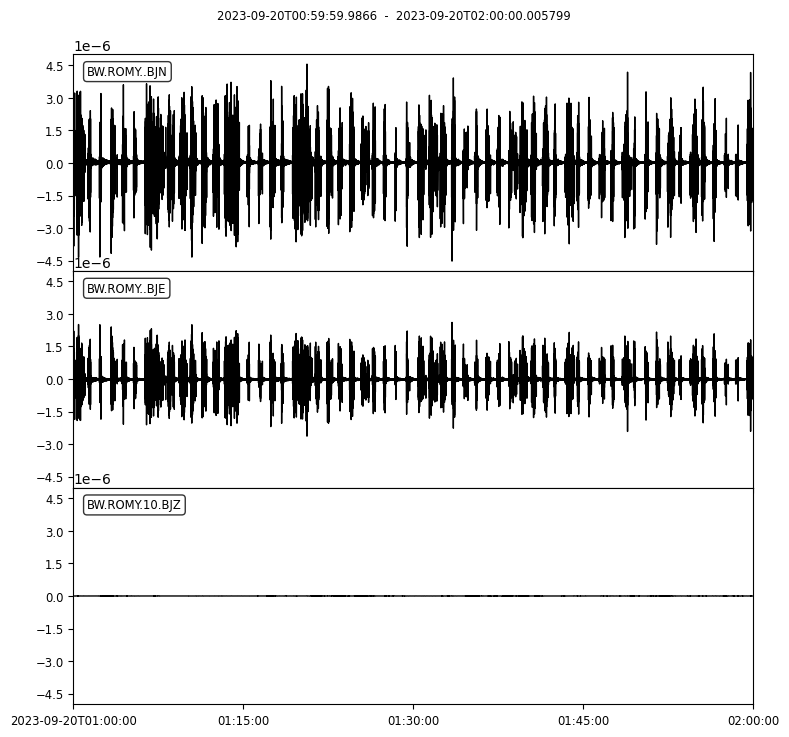

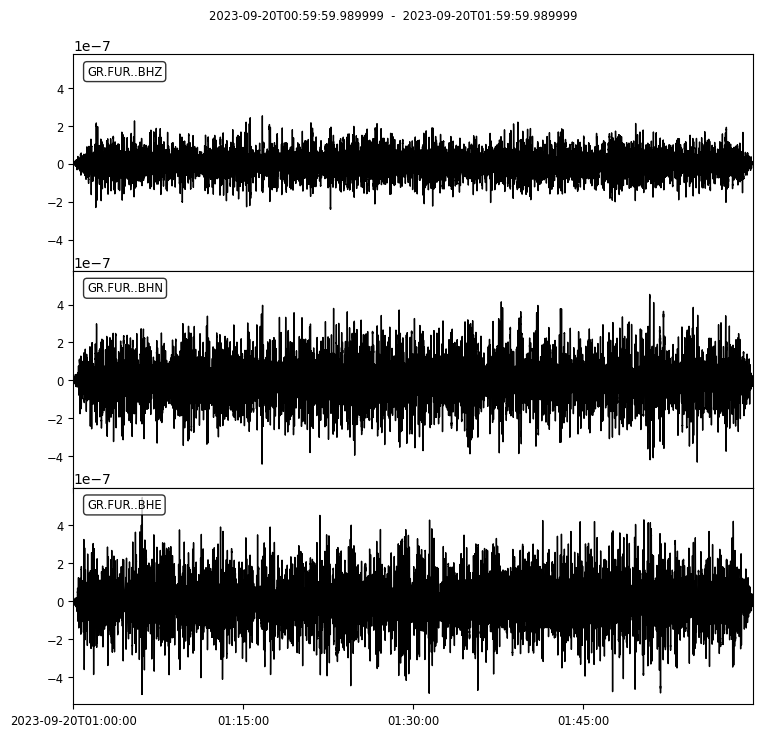

In [10]:
st1.plot();
st2.plot();

## Cross Wavelet Transform

In [11]:
from functions.get_xwt import __compute_cross_wavelet_transform

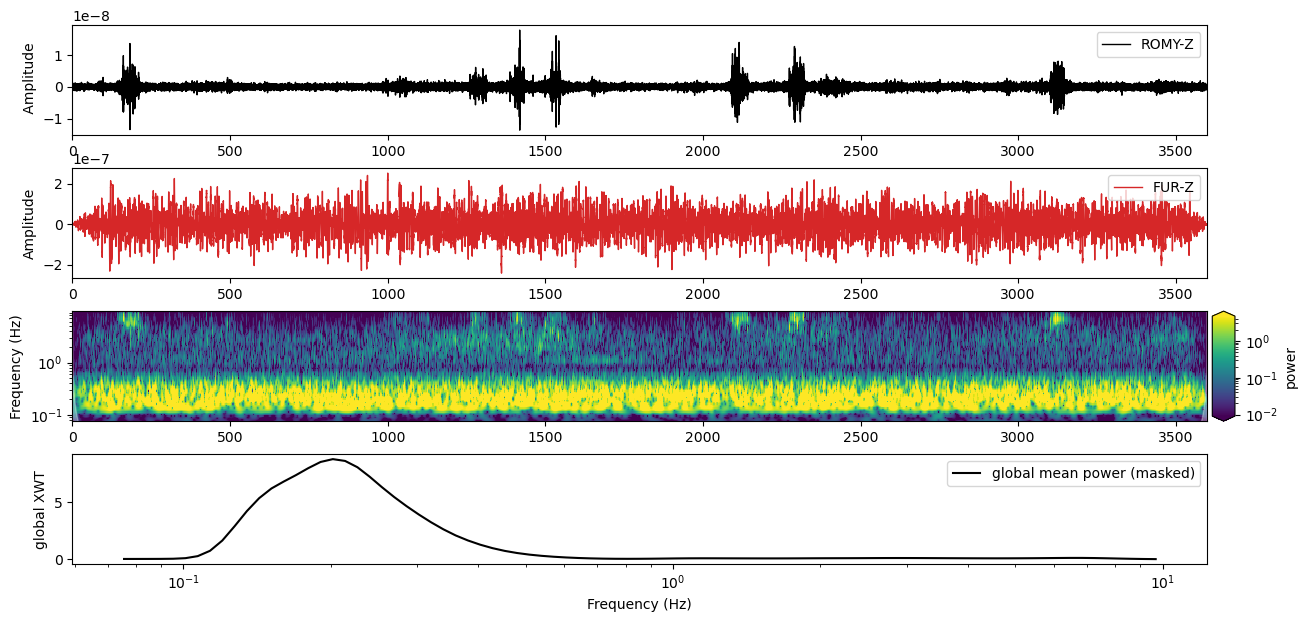

In [12]:
tt = st1[0].times()

dt = st1[0].stats.delta

dat1 = st1[0].data
dat2 = st2[0].data

out = __compute_cross_wavelet_transform(tt, dat1, dat2, dt,
                                        datalabels=["ROMY-Z", "FUR-Z"],
                                        xscale="log",
                                        cmap_scale="log",
                                        plot=True,
                                       )

out['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_XWT_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


## Backazimuth

In [13]:
def __compute_backazimuth(st_acc, st_rot, config, wave_type="love", flim=(None, None), event=None, plot=True, show_details=False):

    """
    This method estimates a backazimuth for either
     - Love waves (vertical rotation rate and transverse acceleration) or
     - Rayleigh waves (vertical acceleration and transverse rotation rate)
    and compares it to a theoretical backazimuth computed from the source and receiver location.


    ARGUMENTS:

    - st_rot:  stream of rotation rate (ideally 3 components with channels *Z,*N,*E)
    - config:  configuration parameters as dictionary. Keywords:
               'tbeg','tend','station_latitude', 'station_longitude', 'step', 'win_length_sec', 'overlap', 'eventtime'
    - wave_type:  "love" or "rayleigh" (default: "love")
    - event:  event obspy object. Default is None. If None USGS catalog is searched for appropriate event.
    - plot:   bool (default: True). Shows plot if set True
    - show_details:  bool (default: False). Shows messages while executing if set True.

    RETURN:
    - out:  dictionary with output data. Keywords:
            'baz_mesh', 'baz_corr', 'baz_theo', 'acc_transverse', 'acc_radial', 'rot_vertical', 'event'

    >>> out = __compute_backazimuth(st_acc, st_rot, config, wave_type="love", event=None, plot=True, show_details=False)

    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    from numpy import ones, arange, linspace, asarray, array, meshgrid, round, shape
    from pprint import pprint
    from obspy import read, read_events, UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from obspy.signal.rotate import rotate_ne_rt

    ## _______________________________
    ## check config
    keywords=['tbeg','tend','station_latitude', 'station_longitude',
              'step', 'win_length_sec', 'overlap', 'eventtime']

    for key in keywords:
        if key not in config.keys():
            print(f" -> {key} is missing in config!\n")
            pprint(keywords)
            return


    ## _______________________________
    ## Defaults
    if 'win_length_sec' not in config.keys():
        config['win_length_sec'] = .5    ## window length for correlation
    if 'step' not in config.keys():
        config['step'] = 1
    if 'overlap' not in config.keys():
        config['overlap'] = 25


    ## time period
    config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])

    if event is not None:
        config['eventime'] = UTCDateTime(config['eventtime'])

    ## _______________________________
    ## prepare streams
    if wave_type == "love":
        ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        ROT = st_rot.copy().trim(config['tbeg'], config['tend'])

        ## revert polarity for Z
        # for tr in ROT:
        #     if "Z" in tr.stats.channel:
        #         tr.data *= -1

    elif wave_type == "rayleigh":
        # ACC = st_acc.copy().trim(config['tbeg'], config['tend'])
        # ROT = st_rot.copy().trim(config['tbeg'], config['tend'])
        ACC = st_acc.copy()
        ROT = st_rot.copy()

    ## _______________________________
    ## get event if not provided
    if event == "auto":
        try:
            events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
            if len(events) > 1:
                print(f" -> {len(events)} events found!!!")
                print(events)
                event = events[0]
        except:
            print(" -> no event found in USGS catalog")


    ## event location from event info
    if event is not None:
        config['source_latitude'] = event.origins[0].latitude
        config['source_longitude'] = event.origins[0].longitude

        if show_details:
            print(" -> event used for theoretical backazimuth:")
            print(" -> ", event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")


        ## _______________________________
        ## theoretical backazimuth and distance

        config['baz'] = gps2dist_azimuth(
                                        config['source_latitude'], config['source_longitude'],
                                        config['station_latitude'], config['station_longitude'],
                                        )
        if show_details:
            print(f" -> Epicentral distance [m]:       {round(config['baz'][0],1)}")
            print(f" -> Theoretical azimuth [deg]:     {round(config['baz'][1],1)}")
            print(f" -> Theoretical backazimuth [deg]: {round(config['baz'][2],1)}")

    ## _______________________________
    ## backazimuth estimation with Love or Rayleigh waves

    config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)

    config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    backas = linspace(0, 360 - config['step'], int(360 / config['step']))

    corrbaz = []

    ind = None

    config['num_windows']

    for i_deg in range(0, len(backas)):

        for i_win in range(0, config['num_windows']):

            ## infer indices
            idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
            idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))

            ## add overlap
            if i_win > 0 and i_win < config['num_windows']:
                idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])

            ## prepare traces according to selected wave type
            if wave_type == "love":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT
                R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data,
                                    ACC.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
#                 corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,)
                ccorr = correlate(ROT.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            elif wave_type == "rayleigh":

                if show_details and i_deg == 0 and i_win == 0:
                    print(f"\n -> using {wave_type} waves for estimation ...")

                ## rotate NE to RT

                R, T = rotate_ne_rt(ROT.select(channel='*N')[0].data,
                                    ROT.select(channel='*E')[0].data,
                                    backas[i_deg]
                                   )

                ## compute correlation for backazimuth
                ## vertical acceleration has to be reversed for definition of polarization reasons
                ccorr = correlate(-1*ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
                                  demean=True, normalize='naive', method='fft')
#                 ccorr = correlate(ACC.select(channel="*Z")[0][idx1:idx2], T[idx1:idx2], 0,
#                                   demean=True, normalize='naive', method='fft')

                xshift, cc_max = xcorr_max(ccorr)

                if xshift != 0:
                    print(f" -> maximal cc not a shift=0: shift={xshift} | cc={cc_max}")

            else:
                print(f" -> unknown mode {wave_type}!")

            corrbaz.append(cc_max)


    corrbaz = asarray(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


    ## extract maxima
    maxcorr = array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])
    maxcorr_value = array([max(corrbaz[:, l1]) for l1 in range(0, config['num_windows'])])

    ## create mesh grid
    t_win = arange(0, config['win_length_sec']*config['num_windows']+config['win_length_sec'], config['win_length_sec'])
    t_win_center = t_win[:-1]+config['win_length_sec']/2
    mesh = meshgrid(t_win, backas)



    ## _______________________________
    ## Plotting
    def __makeplot():

        ## define figure
        fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ## parameters
        font = 12

        acc_scaling, acc_unit = 1e3, "mm/s$^2$"
        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"

        ## create time axis
        time = linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

        ## plot vertical rotation rate
        if wave_type == "love":
            ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')
            ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[0].plot(time, T*rot_scaling, label='transverse rotation rate')
            ax[0].set_ylabel(f'trans. rot. rate \n({rot_unit})', fontsize=font)


        ## plot transverse acceleration
        if wave_type == "love":
            ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
            ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
        elif wave_type == "rayleigh":
            ax[1].plot(time, ACC.select(channel="*Z")[0].data*acc_scaling, 'k',label='vertical acceleration')
            ax[1].set_ylabel(f'vert. acc. \n({acc_unit})', fontsize=font)


        ## backazimuth estimation plot
        im = ax[2].pcolormesh(t_win, backas, corrbaz[:-1,:], cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading='auto')

#         ax[2].set_xlim(time[0], time[-1])
        ax[2].set_xlim(t_win[0], t_win[-1])
        ax[2].set_ylim(0, 360)
        ax[2].set_ylabel(u'estimated \n backazimuth (°)', fontsize=font)
        ax[2].set_xlabel('time (s)', fontsize=font)


        ## plot maximal correclation values
        ax[2].plot(t_win_center, maxcorr, '.k')


        if event is not None:
            ## plot theoretical Backazimuth for comparison
            xx = arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
            tba = ones(len(xx)) * config['baz'][2]
            ax[2].plot(xx, tba, lw=1.5, alpha=0.7, color="k", ls="--")


            ## add label for theoretical backazimuth
            baz_label = u'Theor. BAZ = '+str(round(config['baz'][2],0))+'°'
            if config['baz'][2] < 330:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]+5
            else:
                x_text, y_text = time[int(0.78*len(time))], config['baz'][2]-15
                ax[2].text(x_text, y_text, baz_label, color='k', fontsize=font-2)


            ## epicentral distance
            edist = round(config['baz'][0]/1000, 1)


        ## adjust title
        date = config['tbeg'].date
        t1, t2 = str(config['tbeg'].time).split(".")[0], str(config['tend'].time).split(".")[0]
        try:
            if flim[0] is not None and flim[1] is not None:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km | {flim[0]}-{flim[1]} Hz", fontsize=font-1)
            else:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Epicentral Distance = {edist} km", fontsize=font-1)
        except:
            try:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC | Twin = {config['win_length_sec']} s | {flim[0]}-{flim[1]} Hz | {round(1/flim[1], 1)}-{round(1/flim[0],1)} s", fontsize=font-1)
            except:
                ax[0].set_title(f" {date} | {t1} - {t2} UTC", fontsize=font-1)

        ## tune tick size
        for i in range(3):
            ax[i].tick_params(axis="y", labelsize=font-1)
            ax[i].tick_params(axis="x", labelsize=font-1)
            ax[i].set_xlim(time[0], time[-1])

        ## add legends
        ax[0].legend(loc=1, fontsize=font-2)
        ax[1].legend(loc=1, fontsize=font-2)

        ## adjust tick label style
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


        ## add colorbar
        cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
        cb1 = plt.colorbar(im, ax=ax[2], cax=cax)
        cb1.set_label("CC Coefficient", fontsize=font)

        plt.show();
        return fig

    if plot:
        fig = __makeplot();


    ## _______________________________
    ## prepare output

    output = {}

    output['baz_mesh'] = mesh
    output['baz_corr'] = corrbaz
    output['acc'] = ACC
    output['rot'] = ROT
    output['event'] = event
    output['cc_max_t'] = t_win_center
    output['cc_max_y'] = maxcorr
    output['cc_max'] = maxcorr_value

    if event is not None:
        output['baz_theo'] = config['baz'][2]

    if plot:
        output['fig'] = fig

    return output

## End of File

In [14]:
acc = st2.copy();
rot = st1.copy();

fmin, fmax = 1/10, 1/7

acc = acc.detrend("linear");
acc = acc.taper(0.01);
acc = acc.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

rot = rot.detrend("linear");
rot = rot.taper(0.01);
rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

In [15]:
conf = {}

conf['eventtime'] = config['tbeg']

conf['tbeg'] = config['tbeg']
conf['tend'] = config['tend']

conf['station_longitude'] = 11.275501
conf['station_latitude']  = 48.162941

## specify window length for baz estimation in seconds
conf['win_length_sec'] = 5/fmin

## define an overlap for the windows in percent (50 -> 50%)
conf['overlap'] = 50

## specify steps for degrees of baz
conf['step'] = 1

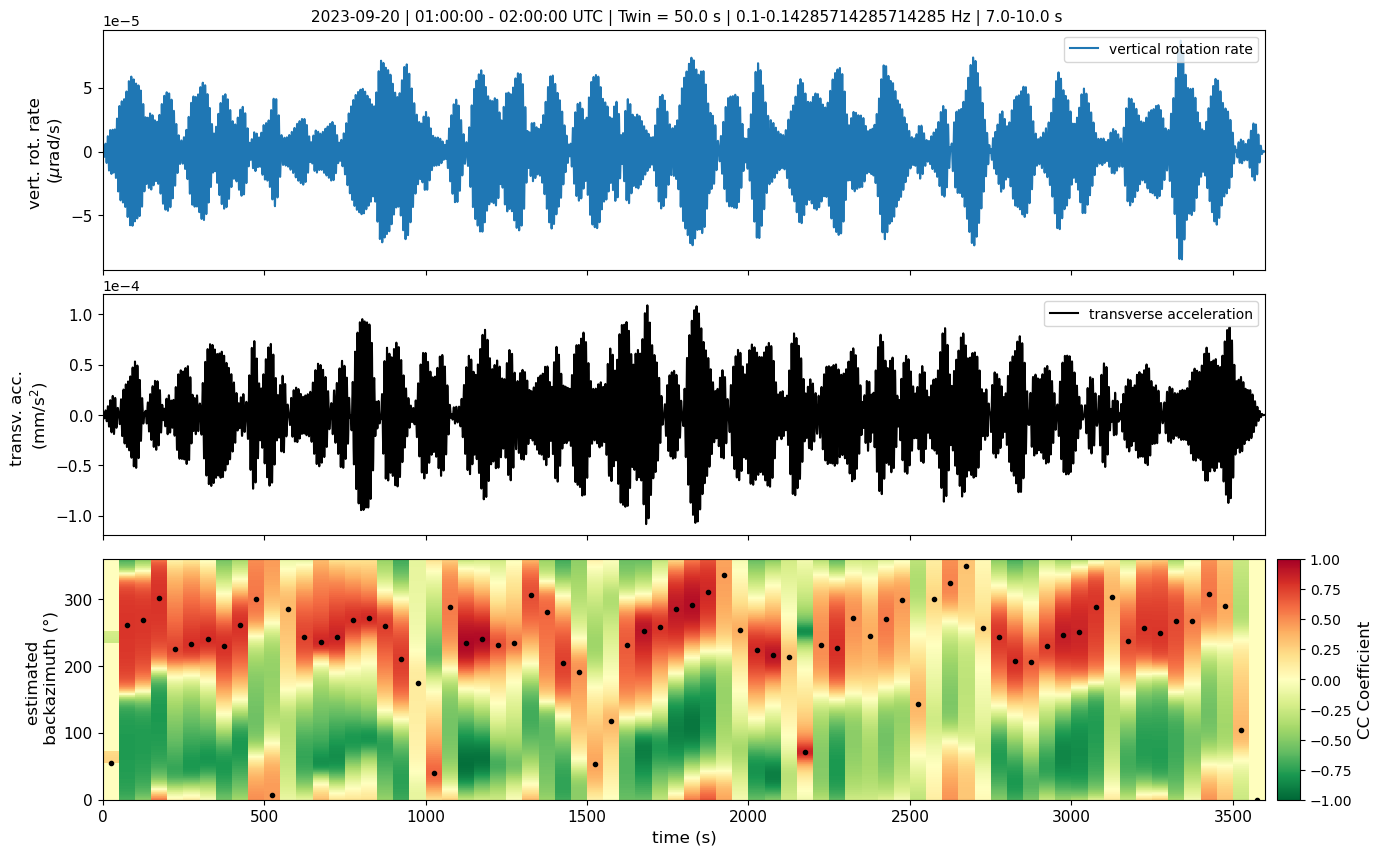

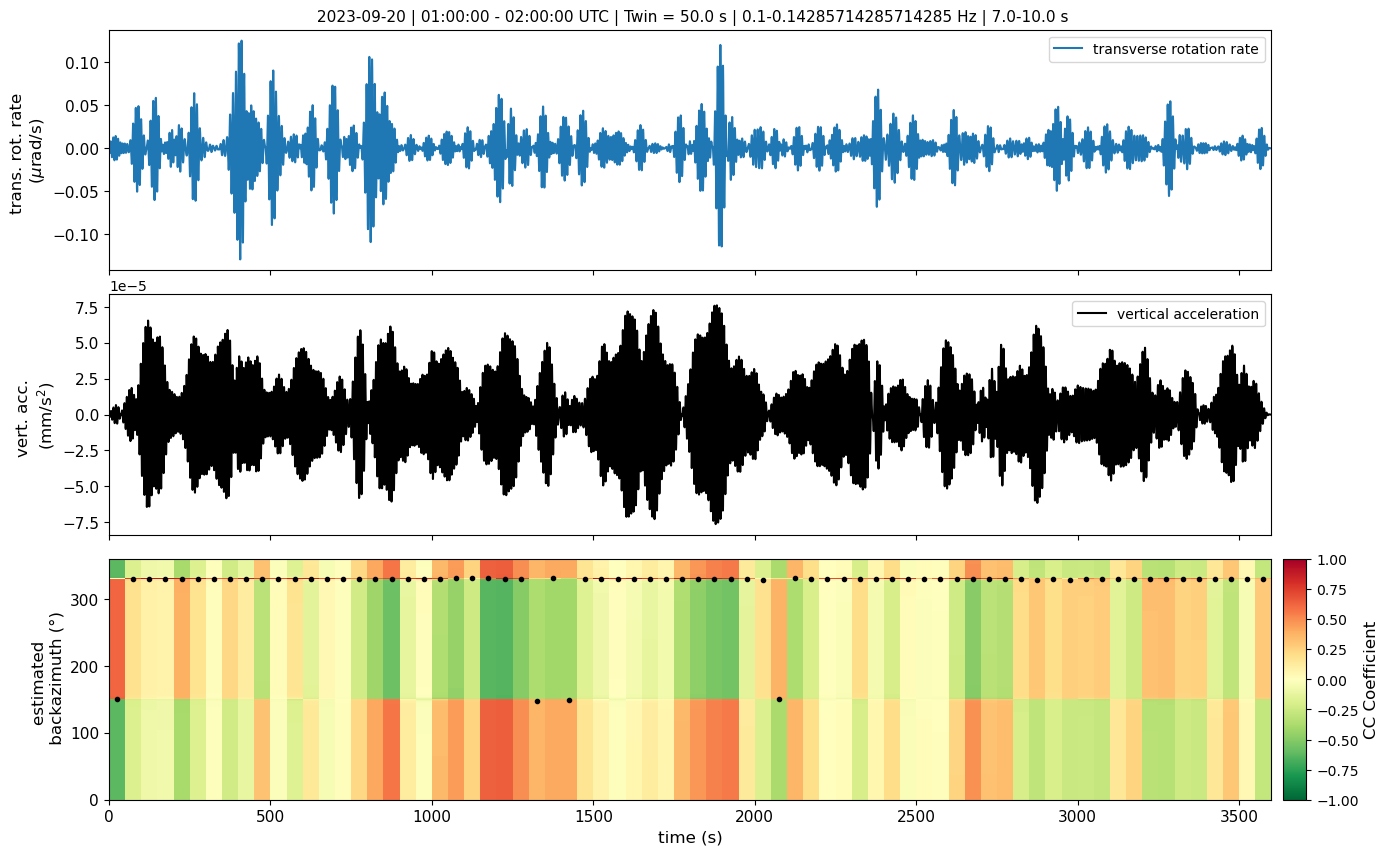

In [16]:
out1 = __compute_backazimuth(
                            acc,
                            rot,
                            conf,
                            wave_type='love',
                            event=None,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
                            )

out1['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_BAZ_Love_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


out2 = __compute_backazimuth(
                            acc,
                            rot,
                            conf,
                            wave_type='rayleigh',
                            event=None,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
                            )

out2['fig'].savefig(config['path_to_figures']+f"Waveforms_FUR_ROMY_BAZ_Rayleigh_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [17]:
def __compare_backazimuth_codes(rot0, acc0, cat_event, fmin, fmax, cc_thres=None, plot=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange, zeros
    from obspy import UTCDateTime
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    rot = rot0.copy()
    acc = acc0.copy()

    rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = {}

    config['tbeg'] = rot[0].stats.starttime
    config['tend'] = rot[0].stats.endtime

    ## Eventtime
    if cat_event is not None:
        config['eventtime'] = UTCDateTime(cat_event.origins[0].time)
    else:
        config['eventtime'] = UTCDateTime(rot[0].stats.starttime)


    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = 2/fmin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = 75

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    if cat_event is None:
        out2['baz_theo'] = 0

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s=config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=cc_thres,
                                        plot=False,
    )

    ## filter according to cc-threshold
    if cc_thres:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= cc_thres:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= cc_thres:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= cc_thres:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    ## statistics of backazimuth
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    try:
        baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
        cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

        hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

        baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
        baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

        # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan)
        baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]

        ## ______________________________________
        ## Love
        baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
        cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

        hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

        baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
        baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

        # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
        baz_love_max = angles2[argmax(kde2.pdf(angles2))]

        ## ______________________________________
        ## Tangent
        baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
        cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

        hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

        baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
        baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

        # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
        baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]

    except Exception as e:
        print(e)
        pass

    ## statistics of velocities
    delta_vel = 200
    velocities = arange(0, 4000, delta_vel)
    velocities_fine = arange(0, 400, 50)


    try:
        ## Rayleigh
        vel_rayleigh_no_nan, cc_vel_rayleigh_no_nan = zeros(len(out1['vel'])), zeros(len(out1['cc_max']))
        for _k, (_v, _c) in enumerate(zip(out1['vel'], out1['cc_max'])):
            if not isnan(_v) and not isnan(_c):
                vel_rayleigh_no_nan[_k] = _v
                cc_vel_rayleigh_no_nan[_k] = _c

        hist = histogram(out1['vel'], bins=len(velocities)-1, range=[min(velocities), max(velocities)], weights=out1['cc_max'], density=True)

        vel_rayleigh_mean = round(average(vel_rayleigh_no_nan, weights=cc_vel_rayleigh_no_nan), 0)
        vel_rayleigh_std = sqrt(cov(vel_rayleigh_no_nan, aweights=cc_vel_rayleigh_no_nan))

        vel_kde1 = sts.gaussian_kde(vel_rayleigh_no_nan, weights=cc_vel_rayleigh_no_nan)
        vel_rayleigh_max = velocities_fine[argmax(vel_kde1.pdf(velocities_fine))]

        ## Love
        vel_love_no_nan, cc_vel_love_no_nan = zeros(len(out2['vel'])), zeros(len(out2['cc_max']))
        for _k, (_v, _c) in enumerate(zip(out2['vel'], out2['cc_max'])):
            if not isnan(_v) and not isnan(_c):
                vel_love_no_nan[_k] = _v
                cc_vel_love_no_nan[_k] = _c

        hist = histogram(out2['vel'], bins=len(velocities)-1, range=[min(velocities), max(velocities)], weights=out2['cc_max'], density=True)

        vel_love_mean = round(average(vel_love_no_nan, weights=cc_vel_love_no_nan), 0)
        vel_love_std = sqrt(cov(vel_love_no_nan, aweights=cc_vel_love_no_nan))

        vel_kde2 = sts.gaussian_kde(vel_love_no_nan, weights=cc_vel_love_no_nan)
        vel_love_max = velocities_fine[argmax(vel_kde2.pdf(velocities_fine))]

    except Exception as e:
        print("no velocities")
        print(e)
        pass

    ## ______________________________________
    ## Plotting

    if False:

        NN = 6
        rot_scaling, rot_unit = 1e9, r"nrad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        fig1, ax = plt.subplots(NN, 1, figsize=(15, 10), sharex=True)

        plt.subplots_adjust(hspace=0.2)

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, baz_tangent_max)
        jr, jt = rotate_ne_rt(jn.data, je.data, baz_tangent_max)

        ## reverse polarity of transverse rotation!!
        jt *= -1

        t1, t2 = hz.times().min(), hz.times().max()

        ax[0].plot(hz.times(), ht*trans_scaling, 'black', label=f"FUR.BHT")
        ax[1].plot(hz.times(), hr*trans_scaling, 'black', label=f"FUR.BHR")
        ax[2].plot(hz.times(), hz.data*trans_scaling, 'black', label=f"FUR.BHZ")

        ax[0].set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax[1].set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax[2].set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax[0].twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"ROMY.BJZ")

        ax11 = ax[1].twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax22 = ax[2].twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax[3].scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax[4].scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax[5].scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax[3].inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax[3], cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax[4].inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax[4], cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax[5].inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax[5], cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax[3].set_ylabel(f"Rayleigh Baz.(°)")
        ax[4].set_ylabel(f"Love Baz.(°)")
        ax[5].set_ylabel(f"CoVar. Baz.(°)")


        ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

        ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

        ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

        for i in [0,1,2]:
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            ax[i].legend(loc=1)
            ax[i].set_ylabel(f"a ({trans_unit})")

        for i in [3,4,5]:
            ax[i].set_ylim(-5, 365)
            ax[i].set_yticks(range(0,360+60,60))
            ax[i].grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            # ax[i].set_ylabel(f"Baz.(°)")
            # ax[i].plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            # ax[i].fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax[0].set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax[5].set_xlabel("Time (s)")

        plt.show();


    if False:

        fig2, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)
        ax[0].plot(angles, kde1.pdf(angles), c='C1', lw=2, label='KDE')
        ax[0].axvline(baz_rayleigh_max, color="r")
        # ax[0].axvline(baz_rayleigh_mean, color="g")
        ax[0].set_title("Rayleigh")
        ax[0].set_xlabel("Backazimuth")
        ax[0].set_ylabel("Density")

        ax[1].hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)
        ax[1].plot(angles, kde2.pdf(angles), c='C1', lw=2, label='KDE')
        ax[1].axvline(baz_love_max, color="r")
        # ax[1].axvline(baz_love_mean, color="g")
        ax[1].set_title("Love")
        ax[1].set_xlabel("Backazimuth")

        ax[2].hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)
        ax[2].plot(angles, kde3.pdf(angles), c='C1', lw=2, label='KDE')
        ax[2].axvline(baz_tangent_max, color="r")
        # ax[2].axvline(baz_tangent_mean, color="g")
        ax[2].set_title("Co.Var.")
        ax[2].set_xlabel("Backazimuth")
        plt.show();


    if plot:

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 8, 6

        fig3 = plt.figure(figsize=(15, 10))

        gs = GridSpec(Nrow, Ncol, figure=fig3, hspace=0.15)

        ax0 = fig3.add_subplot(gs[0, :])
        ax1 = fig3.add_subplot(gs[1, :])
        ax2 = fig3.add_subplot(gs[2, :])

        ax3 = fig3.add_subplot(gs[3, :])
        ax4 = fig3.add_subplot(gs[4, :])
        ax5 = fig3.add_subplot(gs[5, :])

        ax6 = fig3.add_subplot(gs[3, 7:])
        ax7 = fig3.add_subplot(gs[4, 7:])
        ax8 = fig3.add_subplot(gs[5, 7:])

        ax6.set_axis_off()
        ax7.set_axis_off()
        ax8.set_axis_off()

        for _ax in [ax0, ax1, ax2, ax3, ax4]:
            _ax.set_xticklabels([])

        rot_scaling, rot_unit = 1e9, r"nrad/s"
        trans_scaling, trans_unit = 1e6, r"$\mu$m/s$^2$"

        font = 12

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, baz_tangent_max)
        jr, jt = rotate_ne_rt(jn.data, je.data, baz_tangent_max)

        ## reverse polarity of transverse rotation!!
        jt *= -1

        ax0.plot(hz.times(), ht*trans_scaling, 'black', label=f"FUR.BHT")
        ax1.plot(hz.times(), hr*trans_scaling, 'black', label=f"FUR.BHR")
        ax2.plot(hz.times(), hz.data*trans_scaling, 'black', label=f"FUR.BHZ")

        ax0.set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax1.set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax2.set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax0.twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"ROMY.BJZ")

        ax11 = ax1.twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax22 = ax2.twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax3.scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax4.scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax5.scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax3.inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax3, cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax4.inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax4, cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax5.inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax5, cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax3.set_ylabel(f"Rayleigh Baz.(°)")
        ax4.set_ylabel(f"Love Baz.(°)")
        ax5.set_ylabel(f"CoVar. Baz.(°)")

        ax66 = ax6.twinx()
        ax66.hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out1['cc_max'], orientation="horizontal", density=True, color="grey")
        ax66.plot(kde1.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax66.axhline(baz_rayleigh_max, color="k", ls="--")
        ax66.set_axis_off()
        ax66.yaxis.tick_right()
        ax66.invert_xaxis()

        ax77 = ax7.twinx()
        ax77.hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out2['cc_max'], orientation="horizontal", density=True, color="grey")
        ax77.plot(kde2.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax77.axhline(baz_love_max, color="k", ls="--")
        ax77.set_axis_off()
        ax77.yaxis.tick_right()
        ax77.invert_xaxis()

        ax88 = ax8.twinx()
        ax88.hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out3['ccoef'], orientation="horizontal", density=True, color="grey")
        ax88.plot(kde3.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax88.axhline(baz_tangent_max, color="k", ls="--")
        ax88.set_axis_off()
        ax88.yaxis.tick_right()
        ax88.invert_xaxis()


        ax0.set_yticks(linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax0.get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax0.get_yticks())))

        ax1.set_yticks(linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax1.get_yticks())))

        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax2.get_yticks())))

        for _ax in [ax0, ax1, ax2]:
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.legend(loc=1)
            _ax.set_ylabel(f"a ({trans_unit})")
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)

        for _ax in [ax3 ,ax4, ax5]:
            _ax.set_ylim(-5, 365)
            _ax.set_yticks(range(0, 360+60, 60))
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)

            # _ax.set_ylabel(f"Baz.(°)")
            # _ax.plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            # _ax.fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax0.set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {round(fmin ,3)}-{round(fmax,3)} Hz | T = {config['win_length_sec']} s | CC > {cc_thres} | {config['overlap']} % overlap")

        ax5.set_xlabel("Time (s)")

        plt.show();

    ## prepare output directory
    out = {}

    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std

    out['vel_love_max'] = vel_love_max
    out['vel_love_std'] = vel_love_std
    out['vel_rayleigh_max'] = vel_rayleigh_max
    out['vel_rayleigh_std'] = vel_rayleigh_std

    if plot:
        # out['fig1'] = fig1
        # out['fig2'] = fig2
        out['fig3'] = fig3

    return out

In [18]:

# out = __compare_backazimuth_codes(rot, acc, None, fmin, fmax, cc_thres=0.1, plot=True);

# out['fig1'].savefig(config['path_to_figures']+f"ROMY_FUR_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
# out['fig2'].savefig(config['path_to_figures']+f"ROMY_FUR_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_his2.png", dpi=200, bbox_inches='tight', pad_inches=0.05);
# out['fig3'].savefig(config['path_to_figures']+f"ROMY_FUR_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_all.png", dpi=200, bbox_inches='tight', pad_inches=0.05);


In [19]:
from functions.compute_backazimuth_and_velocity_noise import __compute_backazimuth_and_velocity_noise

In [20]:
# %load functions/compute_backazimuth_and_velocity_noise.py
def __compute_backazimuth_and_velocity_noise(conf, rot0, acc0, fmin, fmax, plot=False, save=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange, zeros
    from obspy import UTCDateTime
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    ## minimum number of data points for histogram
    min_num_of_datapoints = 10

    ## rotation and acceleration data
    rot = rot0.copy()
    acc = acc0.copy()

    ## remove mean and filter
    rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = conf

#     config['tbeg'] = rot[0].stats.starttime
#     config['tend'] = rot[0].stats.endtime

#     ## Eventtime
#     config['eventtime'] = UTCDateTime(rot[0].stats.starttime)


#     ## specify coordinates of station
#     config['station_longitude'] =  -116.455439
#     config['station_latitude']  = 33.6106

#     ## specify window length for baz estimation in seconds
#     config['win_length_sec'] = 2/fmin

#     ## define an overlap for the windows in percent (50 -> 50%)
#     config['overlap'] = 75

#     ## specify steps for degrees of baz
#     config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=None,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=None,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    ## set random theo. baz.
    out2['baz_theo'] = 0

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s=config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=config['cc_thres'],
                                        plot=False,
    )

    ## filter according to cc-threshold
    if config['cc_thres']:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= config['cc_thres']:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= config['cc_thres']:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= config['cc_thres']:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    ## statistics of backazimuth
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    try:
        baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
        cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

        hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

        baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
        baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

        kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan)

        if len(baz_rayleigh_no_nan) > min_num_of_datapoints:
            baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]
        else:
            baz_rayleigh_max = nan

        ## ______________________________________
        ## Love
        baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
        cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

        hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

        baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
        baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

        # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)

        if len(baz_love_no_nan) > min_num_of_datapoints:
            baz_love_max = angles2[argmax(kde2.pdf(angles2))]
        else:
            baz_love_max = nan

        ## ______________________________________
        ## Tangent
        baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
        cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

        hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

        baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
        baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

        kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)

        if len(baz_tangent_no_nan) > min_num_of_datapoints:
            baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]
        else:
            baz_lbaz_tangent_maxove_max = nan

    except Exception as e:
        print(e)
        pass

    ## statistics of velocities
    delta_vel = 200
    velocities = arange(0, 4000, delta_vel)
    velocities_fine = arange(0, 400, 50)


    try:
        ## Rayleigh
        vel_rayleigh_no_nan, cc_vel_rayleigh_no_nan = zeros(len(out1['vel'])), zeros(len(out1['cc_max']))
        for _k, (_v, _c) in enumerate(zip(out1['vel'], out1['cc_max'])):
            if not isnan(_v) and not isnan(_c):
                vel_rayleigh_no_nan[_k] = _v
                cc_vel_rayleigh_no_nan[_k] = _c

        hist = histogram(out1['vel'], bins=len(velocities)-1, range=[min(velocities), max(velocities)], weights=out1['cc_max'], density=True)

        vel_rayleigh_mean = round(average(vel_rayleigh_no_nan, weights=cc_vel_rayleigh_no_nan), 0)
        vel_rayleigh_std = sqrt(cov(vel_rayleigh_no_nan, aweights=cc_vel_rayleigh_no_nan))

        vel_kde1 = sts.gaussian_kde(vel_rayleigh_no_nan, weights=cc_vel_rayleigh_no_nan)

        if len(vel_rayleigh_no_nan) > min_num_of_datapoints:
            vel_rayleigh_max = velocities_fine[argmax(vel_kde1.pdf(velocities_fine))]
        else:
            vel_rayleigh_max = nan

        ## Love
        vel_love_no_nan, cc_vel_love_no_nan = zeros(len(out2['vel'])), zeros(len(out2['cc_max']))
        for _k, (_v, _c) in enumerate(zip(out2['vel'], out2['cc_max'])):
            if not isnan(_v) and not isnan(_c):
                vel_love_no_nan[_k] = _v
                cc_vel_love_no_nan[_k] = _c

        hist = histogram(out2['vel'], bins=len(velocities)-1, range=[min(velocities), max(velocities)], weights=out2['cc_max'], density=True)

        vel_love_mean = round(average(vel_love_no_nan, weights=cc_vel_love_no_nan), 0)
        vel_love_std = sqrt(cov(vel_love_no_nan, aweights=cc_vel_love_no_nan))

        vel_kde2 = sts.gaussian_kde(vel_love_no_nan, weights=cc_vel_love_no_nan)

        if len(vel_love_no_nan) > min_num_of_datapoints:
            vel_love_max = velocities_fine[argmax(vel_kde2.pdf(velocities_fine))]
        else:
            vel_love_max = nan

    except Exception as e:
        print("no velocities")
        print(e)
        pass

    ## ______________________________________
    ## Plotting

    if plot or save:

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 8, 7

        fig3 = plt.figure(figsize=(15, 12))

        gs = GridSpec(Nrow, Ncol, figure=fig3, hspace=0.15)

        ax0 = fig3.add_subplot(gs[0, :])
        ax1 = fig3.add_subplot(gs[1, :])
        ax2 = fig3.add_subplot(gs[2, :])

        ax3 = fig3.add_subplot(gs[3, :])
        ax4 = fig3.add_subplot(gs[4, :])
        ax5 = fig3.add_subplot(gs[5, :])

        ax6 = fig3.add_subplot(gs[3, 7:])
        ax7 = fig3.add_subplot(gs[4, 7:])
        ax8 = fig3.add_subplot(gs[5, 7:])

        ax9 = fig3.add_subplot(gs[6, :])

        ax6.set_axis_off()
        ax7.set_axis_off()
        ax8.set_axis_off()

        for _ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
            _ax.set_xticklabels([])

        rot_scaling, rot_unit = 1e9, r"nrad/s"
        trans_scaling, trans_unit = 1e6, r"$\mu$m/s$^2$"

        font = 12

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, baz_tangent_max)
        jr, jt = rotate_ne_rt(jn.data, je.data, baz_tangent_max)

        ## reverse polarity of transverse rotation!!
        jt *= -1

        ax0.plot(hz.times(), ht*trans_scaling, 'black', label=f"FUR.BHT")
        ax1.plot(hz.times(), hr*trans_scaling, 'black', label=f"FUR.BHR")
        ax2.plot(hz.times(), hz.data*trans_scaling, 'black', label=f"FUR.BHZ")

        ax0.set_ylim(-max(abs(ht*trans_scaling)), max(abs(ht*trans_scaling)))
        ax1.set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))
        ax2.set_ylim(-max(abs(hz.data*trans_scaling)), max(abs(hz.data*trans_scaling)))

        ax00 = ax0.twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"ROMY.BJZ")

        ax11 = ax1.twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax22 = ax2.twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"-1x ROMY.BJT")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax3.scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca4 = ax4.scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca5 = ax5.scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        ca9 = ax9.scatter(out1['cc_max_t'], out1['vel'], c=out1['cc_max'], marker='s', label="Rayleigh",
                          s=30, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ca9 = ax9.scatter(out2['cc_max_t'], out2['vel'], c=out2['cc_max'], marker='^', label="Love",
                          s=30, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax3.inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax3, cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax4.inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax4, cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax5.inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax5, cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        cax9 = ax9.inset_axes([1.01, 0., 0.02, 1])
        cb9 = plt.colorbar(ca9, ax=ax9, cax=cax9)
        cb9.set_label("CC-Coeff.", fontsize=font)

        ax3.set_ylabel(f"Rayleigh Baz. (°)")
        ax4.set_ylabel(f"Love Baz. (°)")
        ax5.set_ylabel(f"CoVar. Baz. (°)")
        ax9.set_ylabel(f"Phase Velocity (m/s)")

        ax66 = ax6.twinx()
        ax66.hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out1['cc_max'], orientation="horizontal", density=True, color="grey")
        ax66.plot(kde1.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax66.axhline(baz_rayleigh_max, color="k", ls="--")
        ax66.set_axis_off()
        ax66.yaxis.tick_right()
        ax66.invert_xaxis()

        ax77 = ax7.twinx()
        ax77.hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out2['cc_max'], orientation="horizontal", density=True, color="grey")
        ax77.plot(kde2.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax77.axhline(baz_love_max, color="k", ls="--")
        ax77.set_axis_off()
        ax77.yaxis.tick_right()
        ax77.invert_xaxis()

        ax88 = ax8.twinx()
        ax88.hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out3['ccoef'], orientation="horizontal", density=True, color="grey")
        ax88.plot(kde3.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax88.axhline(baz_tangent_max, color="k", ls="--")
        ax88.set_axis_off()
        ax88.yaxis.tick_right()
        ax88.invert_xaxis()


        ax0.set_yticks(linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax0.get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax0.get_yticks())))

        ax1.set_yticks(linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax1.get_yticks())))

        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax2.get_yticks())))

        for _ax in [ax0, ax1, ax2]:
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.legend(loc=1)
            _ax.set_ylabel(f"a ({trans_unit})")
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)

        for _ax in [ax3 ,ax4, ax5]:
            _ax.set_ylim(-5, 365)
            _ax.set_yticks(range(0, 360+60, 60))
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)

            # _ax.set_ylabel(f"Baz.(°)")
            # _ax.plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            # _ax.fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", ls="--", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\omega$ ({rot_unit})", color="darkred")
            aaxx.legend(loc=4)

        ax0.set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {round(fmin ,3)}-{round(fmax,3)} Hz | T = {config['win_length_sec']} s | CC > {config['cc_thres']} | {config['overlap']} % overlap")

        ax9.set_xlabel("Time (s)")
        ax9.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
        ax9.set_xlim(0, (config['tend']-config['tbeg'])*1.15)
        ax9.legend(loc=1, fontsize=font-1)

        if plot:
            plt.show();

    ## prepare output directory
    out = {}

    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std

    out['baz_rayleigh_all'] = out1['cc_max_y']
    out['baz_love_all'] = out2['cc_max_y']
    out['baz_tangent_all'] = out3['baz_est']

    out['vel_love_max'] = vel_love_max
    out['vel_love_std'] = vel_love_std
    out['vel_rayleigh_max'] = vel_rayleigh_max
    out['vel_rayleigh_std'] = vel_rayleigh_std

    out['vel_rayleigh_all'] = out1['vel']
    out['vel_love_all'] = out2['vel']

    out['times_relative'] = out1['cc_max_t']

    if plot or save:
        # out['fig1'] = fig1
        # out['fig2'] = fig2
        out['fig3'] = fig3

    return out

In [ ]:
conf = config

conf['eventtime'] = config['tbeg']

conf['station_longitude'] = 11.275501
conf['station_latitude']  = 48.162941

## specify window length for baz estimation in seconds
conf['win_length_sec'] = 2/fmin

## define an overlap for the windows in percent (50 -> 50%)
conf['overlap'] = 90

## specify steps for degrees of baz
conf['step'] = 1

conf['cc_thres'] = 0.1


out = __compute_backazimuth_and_velocity_noise(conf, rot, acc, fmin, fmax, plot=True);

# out['fig3'].savefig(config['path_to_figures']+f"ROMY_FUR_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05);


### Beamforming

In [ ]:
from functions.compute_beamforming_ROMY import __compute_beamforming_ROMY

In [ ]:
def __compute_beamforming_ROMY(tbeg, tend, submask=None, fmin=None, fmax=None, component="Z", bandpass=True, plot=False):

    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import scipy.stats as sts

    from obspy import UTCDateTime, Stream
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from obspy.core.util import AttribDict
    from obspy.imaging.cm import obspy_sequential
    from obspy.signal.invsim import corn_freq_2_paz
    from obspy.signal.array_analysis import array_processing
    from datetime import datetime
    from matplotlib.colorbar import ColorbarBase
    from matplotlib.colors import Normalize

    import warnings
    warnings.filterwarnings('ignore')

    ## _____________________________________________________

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        for k, station in enumerate(config['subarray_stations']):

            net, sta, loc, cha = station.split(".")[0], station.split(".")[1], "", f"BH{config['component']}"

            # print(f" -> requesting {net}.{sta}.{loc}.{cha}")


            ## querry inventory data
            try:
                inventory = Client(config['fdsn_clients'][k]).get_stations(
                                                                             network=net,
                                                                             station=sta,
                                                                             # channel=cha,
                                                                             starttime=config['tbeg']-20,
                                                                             endtime=config['tend']+20,
                                                                             level="response"
                                                                            )
            except Exception as e:
                print(e)
                print(f" -> {station}: Failed to load inventory!")
                inventory = None

            ## try to get waveform data
            try:
                stats = Client(config['fdsn_clients'][k]).get_waveforms(
                                                                        network=net,
                                                                        station=sta,
                                                                        location=loc,
                                                                        channel=cha,
                                                                        starttime=config['tbeg']-20,
                                                                        endtime=config['tend']+20,
                                                                        attach_response=True
                                                                        )
            except Exception as e:
                # print(e)
                print(f" -> getting waveforms failed for {net}.{sta}.{loc}.{cha} ...")
                continue


            ## merge if masked
            if len(stats) > 1:
                print(f" -> merging stream. Length: {len(stats)}")
                stats.merge(method=1, fill_value="interpolate")

            if stats[0].stats.sampling_rate != 20.:
                stats.detrend("demean")
                stats.filter("lowpass", freq=18, corners=4, zerophase=True)
                stats.decimate(2, no_filter=True)

            ## remove response [ACC -> m/s/s | VEL -> m/s | DISP -> m]
            try:
                stats.remove_response(inventory=inventory, output="VEL", water_level=10)
            except:
                print(" -> failed to remove response")
                continue


            ## rotate to ZNE
            try:
                stats.rotate(method="->ZNE", inventory=inventory)
            except:
                print(" -> failed to rotate to ZNE")
                continue


            l_lon =  float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat =  float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])


            # for c in ["Z", "N", "E"]:
            stats.select(station=sta, channel=f"*{config['component']}")[0].stats.coordinates = AttribDict({
                                                                                      'latitude': l_lat,
                                                                                      'elevation': height/1000,
                                                                                      'longitude': l_lon
                                                                                       })

            if station == config['reference_station']:
                ref_station = stats.copy()

            # print(stats)

            st += stats


        print(st.__str__(extended=True)) if config['print_details'] else None

        print(f" -> obtained: {int(len(st)/1)} of {len(config['subarray_stations'])} stations!")

        ## update subarray stations if data could not be requested for all stations
        if len(st) < 1*len(config['subarray_stations']):
            config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
            config['subarray_stations'] = list(set(config['subarray_stations']))

        if len(st) == 0:
            return st, config
        else:
            return st, config



    ## _____________________________________________________

    ## start timer for runtime
    start_timer = timeit.default_timer()


    ## generate configuration object
    config = {}

    ## time period of event
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    ## add component
    config['component'] = component

    ## select the fdsn client for the stations


    ## select stations to consider:
    if submask is not None:
        if submask == "inner":
            config['subarray_mask'] = [0,1,2,3]
            config['freq1'] = 0.4
            config['freq2'] = 3.7
        elif submask == "outer":
            config['subarray_mask'] = [0,4,5,6,7,8]
            config['freq1'] = 0.04
            config['freq2'] = 0.3
    else:
        config['subarray_mask'] = [0,1,2,3,4,5,6,7,8]


    ## decide if information is printed while running the code
    config['print_details'] = False

    ## apply bandpass to data
    config['apply_bandpass'] = bandpass


    ## _____________________
    ## PFO array information

    config['reference_station'] = 'GR.FUR' ## 'BPH01'  ## reference station

    config['array_stations'] = ['GR.FUR', 'BW.FFB1', 'BW.FFB2', 'BW.FFB3', 'BW.TON', 'BW.GELB', 'BW.BIB', 'BW.ALFT', 'BW.GRMB']
    config['fdsn_clients'] = ['BGR', 'LMU', 'LMU', 'LMU', 'LMU', 'LMU', 'LMU', 'LMU', 'LMU']

    config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]
    config['fdsn_clients'] = [config['fdsn_clients'][i] for i in config['subarray_mask']]


    ## ______________________________

    ## beamforming parameters
    config['slow_xmin'] = -0.5
    config['slow_xmax'] = 0.5
    config['slow_ymin'] = -0.5
    config['slow_ymax'] = 0.5
    config['slow_steps'] = 0.01

    config['win_length'] = 1/fmin # window length in seconds

    config['win_frac'] = 0.5  # fraction of window to use as steps

    config['freq_lower'] = fmin
    config['freq_upper'] = fmax
    config['prewhitening'] = 0  ## 0 or 1


    ## loading data
    st, config = __get_data(config)

    ## pre-pprocessing data
    st = st.detrend("demean")

    if config['apply_bandpass']:
        st = st.taper(0.1)
        st = st.filter("bandpass", freqmin=config['freq_lower'], freqmax=config['freq_upper'], corners=8, zerophase=True)

    ## add coordinates from inventories
    # st = __add_coordinates(st, config)

    ## select only one component
    st = st.select(channel=f"*{component}")

    st = st.trim(config['tbeg']-0.1, config['tend']+0.1)

    ## define parameters for beamforming
    kwargs = dict(

        # slowness grid: X min, X max, Y min, Y max, Slow Step
        sll_x=config['slow_xmin'], slm_x=config['slow_xmax'],
        sll_y=config['slow_ymin'], slm_y=config['slow_ymax'],
        sl_s=config['slow_steps'],

        # sliding window properties
        win_len=config['win_length'], win_frac=config['win_frac'],

        # frequency properties
        frqlow=config['freq_lower'], frqhigh=config['freq_upper'], prewhiten=config['prewhitening'],

        # restrict output
        semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',

        ## time period
        stime=config['tbeg'], etime=config['tend'],
        # stime=st[0].stats.starttime, etime=st[0].stats.endtime,
    )

    ## perform beamforming
    out = array_processing(st, **kwargs)

    st = st.trim(config['tbeg'], config['tend'])


    ## stop times
    stop_timer = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer - start_timer)/60,2)} minutes")

    ## ______________________________
    ## Plotting

    if plot:

        ## PLOT 1 -----------------------------------
        labels = ['rel.power', 'abs.power', 'baz', 'slow']

        out[:, 3][out[:, 3] < 0.0] += 360

        xlocator = mdates.AutoDateLocator()

        fig1, ax = plt.subplots(5,1, figsize=(15,10))

        Tsec = config['tend']-config['tbeg']
        times = (out[:, 0]-out[:, 0][0]) / max(out[:, 0]-out[:, 0][0]) * Tsec

        for i, lab in enumerate(labels):
            # ax[i].scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
            # ax[i].scatter(times, out[:, i + 1], c=out[:, 1], alpha=0.6, edgecolors='none', cmap=obspy_sequential)
            ax[i].scatter(times, out[:, i + 1], c=out[:, 2], alpha=0.6, cmap=obspy_sequential)
            ax[i].set_ylabel(lab)
            # ax[i].set_xlim(out[0, 0], out[-1, 0])
            ax[i].set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
            ax[i].xaxis.set_major_locator(xlocator)
            ax[i].xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

        ax[4].plot(st[0].times()/st[0].times()[-1]*out[:, 0][-1], st[0].data)
        ax[2].set_ylim(0, 360)
        ax[0].set_ylim(0, 1)

        fig1.autofmt_xdate()

        plt.show();



    ## PLOT 2 -----------------------------------
    cmap = obspy_sequential

    # make output human readable, adjust backazimuth to values between 0 and 360
    t, rel_power, abs_power, baz, slow = out.T
    baz[baz < 0.0] += 360

    # choose number of fractions in plot (desirably 360 degree/N is an integer!)
    N = 36
    N2 = 30
    abins = np.arange(N + 1) * 360. / N
    sbins = np.linspace(0, 3, N2 + 1)


    # sum rel power in bins given by abins and sbins
    # hist2d, baz_edges, sl_edges = np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)
    hist2d, baz_edges, sl_edges = np.histogram2d(baz, slow, bins=[abins, sbins], weights=abs_power)

    # transform to radian
    baz_edges = np.radians(baz_edges)

    if plot:

        # add polar and colorbar axes
        fig2 = plt.figure(figsize=(8, 8))

        cax = fig2.add_axes([0.85, 0.2, 0.05, 0.5])
        ax = fig2.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location("N")

        dh = abs(sl_edges[1] - sl_edges[0])
        dw = abs(baz_edges[1] - baz_edges[0])

        # circle through backazimuth
        for i, row in enumerate(hist2d):
            bars = ax.bar((i * dw) * np.ones(N2),
                          height=dh * np.ones(N2),
                          width=dw, bottom=dh * np.arange(N2),
                          color=cmap(row / hist2d.max()))

        ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
        ax.set_xticklabels(['N', 'E', 'S', 'W'])

        # set slowness limits
        ax.set_ylim(0, config['slow_xmax'])
        [i.set_color('grey') for i in ax.get_yticklabels()]
        ColorbarBase(cax, cmap=cmap, norm=Normalize(vmin=hist2d.min(), vmax=hist2d.max()))

        plt.show();

    max_val = 0
    for i in range(hist2d.shape[0]):
        for j in range(hist2d.shape[1]):
            if hist2d[i,j] > max_val:
                max_val, slw_max, baz_max = hist2d[i,j], sbins[j], abins[i]

    ## prepare output
    baz = out[:, 3]
    baz[baz < 0.0] += 360

    ## compute statistics
    deltaa = 5
    angles = np.arange(0, 365, deltaa)
    angles2 = np.arange(0, 365, 1)

    baz_bf_no_nan = baz[~np.isnan(baz)]
    cc_bf_no_nan = out[:, 2][~np.isnan(out[:, 2])]

    hist = np.histogram(baz, bins=len(angles)-1, range=[min(angles), max(angles)], weights=out[:, 2], density=False)

    baz_bf_mean = round(np.average(baz_bf_no_nan, weights=cc_bf_no_nan), 0)
    baz_bf_std = np.sqrt(np.cov(baz_bf_no_nan, aweights=cc_bf_no_nan))

    kde = sts.gaussian_kde(baz_bf_no_nan, weights=cc_bf_no_nan)
    baz_bf_max = angles2[np.argmax(kde.pdf(angles2))]

    ## convert samples to time in seconds
    _t = out[:, 0] - out[:, 0][0]
    ttime = _t / _t[-1] * ( tend - tbeg )

    ## prepare output dictionary
    output = {}
    output['time'] = ttime
    output['rel_pwr'] = out[:, 1]
    output['abs_pwr'] = out[:, 2]
    output['baz'] = baz
    output['slow'] = out[:, 4]
    output['baz_max_count'] = max_val
    output['baz_max'] = baz_max
    output['slw_max'] = slw_max
    output['baz_bf_mean'] = baz_bf_mean
    output['baz_bf_max'] = baz_bf_max
    output['baz_bf_std'] = baz_bf_std


    if plot:
        output['fig1'] = fig1
        output['fig2'] = fig2

    return output

In [ ]:
out_bf = __compute_beamforming_ROMY(config['tbeg'], config['tend'], submask=None, fmin=fmin, fmax=fmax, component="Z", bandpass=True, plot=True)

In [ ]:
out

In [ ]:
def __compute_velocity(rot0, acc0, baz=None, mode="love", reverse_rotZ=False, reverse_accZ=False, win_time_s=2.0, cc_thres=0.8, overlap=0.5, flim=(None,None), plot=False):

    from scipy.stats import pearsonr
    from numpy import zeros, nan, ones, nanmean, array, nanmax, linspace, std
    from scipy import odr
    from obspy.signal.rotate import rotate_ne_rt
    from obspy.signal.cross_correlation import correlate
    from functions.compute_linear_regression import __compute_linear_regression
    import matplotlib.pyplot as plt

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    sta, loc = rot0[0].stats.station, rot0[0].stats.location

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n, n+n_win))
        n += n_win

    ## invert rotation rate for ADR data
    # if rot0[0].stats.station == "RPFO":
    #     rot0.select(channel="*JZ")[0].data *= -1

    ## rotate channels
    if mode == "love":
        r_acc, t_acc = rotate_ne_rt(acc0.select(channel='*N')[0].data,
                                    acc0.select(channel='*E')[0].data,
                                    baz
                                    )
        acc = t_acc

        ## change polarity !!!
        if reverse_rotZ:
            rot = rot0.select(channel="*JZ")[0].data * -1
        else:
            rot = rot0.select(channel="*JZ")[0].data


    elif mode == "rayleigh":
        r_rot, t_rot = rotate_ne_rt(rot0.select(channel='*N')[0].data,
                                    rot0.select(channel='*E')[0].data,
                                    baz
                                    )
        rot = t_rot

        ## invert vertical acceleration for rayleigh waves
        if reverse_accZ:
            acc = acc0.select(channel="*HZ")[0].data*-1
        else:
            acc = acc0.select(channel="*HZ")[0].data


    ## add overlap
    windows_overlap = []
    for i, w in enumerate(windows):
        if i == 0:
            windows_overlap.append((w[0], w[1]+nover))
        elif i >= (len(windows)-nover):
            windows_overlap.append((w[0]-nover, w[1]))
        else:
            windows_overlap.append((w[0]-nover, w[1]+nover))

    vel, ccor = ones(len(windows_overlap))*nan, zeros(len(windows_overlap))

    ## compute crosscorrelation for each window
    for j, (w1, w2) in enumerate(windows_overlap):

        ## trying to remove very small rotation values
#         rot_win = array([r if r>5e-8 else 0 for r in rot[w1:w2]])
#         acc_win = array([a if r>5e-8 else 0 for a, r in zip(acc[w1:w2], rot[w1:w2])])

        if mode == "love":
            rot_win, acc_win = rot[w1:w2], 0.5*acc[w1:w2]
        elif mode == "rayleigh":
            rot_win, acc_win = rot[w1:w2], acc[w1:w2]

        if len(rot_win) < 10:
            print(f" -> not enough samples in window (<10)")

        ccor[j], p = pearsonr(rot_win, acc_win)
#         ccor[j] = correlate(rot_win, acc_win, 0, 'auto')[0]

        ## if cc value is above threshold perform odr to get velocity
        if ccor[j] > cc_thres:
            data = odr.RealData(rot_win, acc_win)
            out = odr.ODR(data, model=odr.unilinear)
            output = out.run()
            slope, intercept = output.beta
            vel[j] = abs(slope)


    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2


    if plot:

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot)))/df, rot/max(abs(rot)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc)))/df, acc/max(abs(acc)), alpha=0.5, color="tab:red", label=r"acceleration (m/s$^2$)")


        ax.set_ylim(-1, 1)
        ax.set_xlim(0, len(rot)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=2, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, vel, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, label="phase velocity estimate", zorder=2)
        ax2.errorbar(time, vel, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel(r"Phase Velocity (m/s)", fontsize=14)
        ax2.set_ylim(bottom=0)
        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        ax2.legend(loc=1, fontsize=13)

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if mode == "rayleigh":
            formula = r"a$_Z$/$\Omega_T$"
            ax.set_title(f"{sta}{loc} | Rayleigh ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)
        elif mode == "love":
            formula = r"a$_T$/2$\Omega_Z$"
            ax.set_title(f"{sta}{loc} | Love ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)

        out = {"time":time, "velocity":vel, "ccoef":ccor, "terr":terr, "fig":fig}
    else:
        out = {"time":time, "velocity":vel, "ccoef":ccor, "terr":terr, }

    return out

## End of File

## Load BAZ Data

In [ ]:
from pandas import read_pickle
from functions.get_time_intervals import __get_time_intervals

path = "/home/andbro/kilauea-data/VelocityChanges/data/"

# t1, t2 = "2023-12-01", "2023-12-09"
# t1, t2 = "2023-09-20", "2023-09-25"
t1, t2 = "2023-09-23", "2023-09-24"



In [ ]:
from functions.get_time_intervals import __get_time_intervals

In [ ]:
dates = __get_time_intervals(t1 ,t2, interval_seconds=86400, interval_overlap=0)

baz1, baz2, baz3, baz4 = np.array([]), np.array([]), np.array([]), np.array([])
std1, std2, std3, std4 = np.array([]), np.array([]), np.array([]), np.array([])
ttt = np.array([])

for _n, (d1, d2) in enumerate(dates):
    print(d1)
    filename = f"VC_BAZ_{d1.date}_{d2.date}.pkl"

    if os.path.isfile(path+filename):
        out = read_pickle(path+filename)
    try:
        baz1 = np.append(baz1, out['baz_tangent'])
        baz2 = np.append(baz2, out['baz_bf'])
        baz3 = np.append(baz3, out['baz_love'])
        baz4 = np.append(baz4, out['baz_rayleigh'])

        std1 = np.append(std1, out['baz_tangent_std'])
        std2 = np.append(std2, out['baz_bf_std'])
        std3 = np.append(std3, out['baz_love_std'])
        std4 = np.append(std4, out['baz_rayleigh_std'])

        ttt = np.append(ttt, out['time'])

    except:
        print(f" -> skipping: {filename}")

In [ ]:
std1.size, baz1.size

## Plotting

In [ ]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = (ttt-ttt[0])/86400

    ax[0].errorbar(t_axis, baz1, yerr=std1/2, fmt="k.", label="Co.Var.")
    ax[1].errorbar(t_axis, baz4, yerr=std4/2, fmt="k.", label="Rayleigh")
    ax[2].errorbar(t_axis, baz3, yerr=std3/2, fmt="k.", label="Love")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))

    ax[Nrow-1].set_xlabel("Time (days)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

In [ ]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
                     edgecolor='darkred', fill=False, linewidth=0.7)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [ ]:
def __makeplot_polar():

    import matplotlib.pyplot as plt
    import numpy as np

    font = 12

    weight = False

    # Construct figure and axis to plot on
    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), figsize=(8, 8))


    if weight:
        circular_hist(ax[0,0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
        circular_hist(ax[0,1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
        circular_hist(ax[1,0], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
        circular_hist(ax[1,1], np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=True)
    else:
        circular_hist(ax[0,0], np.deg2rad(baz1), density=False)
        circular_hist(ax[0,1], np.deg2rad(baz2), density=False)
        circular_hist(ax[1,0], np.deg2rad(baz3), density=False)
        circular_hist(ax[1,1], np.deg2rad(baz4), density=False)

    ax[0,0].set_title("(a) Co.Var.", loc="left")
    ax[0,1].set_title("(b) Beamforming", loc="left")
    ax[1,0].set_title("(c) Love", loc="left")
    ax[1,1].set_title("(d) Rayleigh", loc="left")

    for i in range(2):
        for j in range(2):
            ax[i,j].grid(color="k", zorder=0, ls="--", alpha=0.5)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({t1} - {t2})", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_polar()

### Plot on Map

In [ ]:
# import gc
# import matplotlib.colors
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import matplotlib.pyplot as mpl
# import cartopy.feature as cfeature

# romy_lon = 11.275501
# romy_lat = 48.162941

# flatMap = ccrs.PlateCarree()
# resolution = '50m'

# fig = plt.figure(figsize=(12, 6), dpi=96)

# ax = fig.add_subplot(111, projection=flatMap)

# ax.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
#           origin='upper',
#           transform=ccrs.PlateCarree(),
#           extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
#          )

# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

# ax1 = fig.add_subplot(111, projection='polar', )

# circular_hist(ax1, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
# # ax1.set_title("Co.Var.")

# ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
# ax1.patch.set_alpha(0.)
# ax1.axis("off")

# gc.collect()

# plt.show();

In [ ]:
rot.plot()